In [2]:
import sys
sys.path.insert(0, './Trees')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import subprocess
from scipy.spatial.distance import *

from Utils_dendrograms_OPT import prune_dendro, from_cloud_to_dendro_sublvl,dendrolink
from top_TED_lineare_multiplicity import top_TED_lineare as TED
from copy import deepcopy

from Interleaving_distance import interleaving, interl_approx

In [3]:
from pool_fn import *

In [4]:
import skfda

from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.datasets import fetch_growth, fetch_octane, fetch_nox, fetch_tecator, fetch_weather  

from scipy.interpolate import interp1d as spline
from scipy.interpolate import CubicSpline as Cspline


In [5]:
from sklearn.cluster import  DBSCAN, OPTICS
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis   
from sklearn.metrics import confusion_matrix
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding

from sklearn.linear_model import LinearRegression

In [6]:
def classify(X,labels):
    
    classes = np.unique(labels)
    N = len(labels)
    n_class= len(classes)

    MAT = np.zeros((n_class,n_class))

    for n in np.arange(2,(len(labels)//2),2):
        for neigh in np.arange(5,len(labels)-1,np.max([3,len(labels)//50])):
            
            print('n=',n,'; neigh=',neigh,'     ',end='\r')
            
            feat=deepcopy(X)
            red_algorithm=Isomap(n_components=n,n_neighbors=neigh).fit(feat)
            feat = red_algorithm.transform(feat)
            err = []
            for alg, clf in enumerate([QuadraticDiscriminantAnalysis(tol=1.0e-10)]):
                matrix=np.zeros((n_class,n_class))

                for test_ in range(N):

                    train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
                    test=[train[test_,:]]
                    train=np.r_[train[:test_,:],train[(test_+1):,:]]            

                    test=np.asarray(test)

                    gr_truth=np.copy(labels)

                    test_truth=[gr_truth[test_]]
                    tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]
                    test_truth=np.asarray(test_truth)

                    tr_red=train
                    test_red=test

                    clf.fit(tr_red, tr_truth)
                    labels_=clf.predict(test_red)

                    if not labels_ == test_truth:
                        err.append(test_)

                    cnf_matrix = confusion_matrix(test_truth,labels_,labels=classes)
                    matrix = matrix+cnf_matrix

                if sum(np.diag(matrix))>sum(np.diag(MAT)):
                    MAT=matrix
                    ENNE=n
                    NEIGH = neigh
                    ERR = err
                        
    return MAT,ENNE,NEIGH,ERR   


def regression(X,y,p=2):
     
    pred = np.zeros_like(y)
    N = len(y)
    
    MSE = []
    
#    for n in np.arange(2,len(y)//2,np.max([1,len(y)//50])):
    for n in np.arange(10,len(y)//2,2):
#        for neigh in np.arange(5,len(y),np.max([1,len(y)//50])):
        for neigh in np.arange(50,len(y)-1,2):
            feat=deepcopy(X)
            red_algorithm=Isomap(n_components=n,n_neighbors=neigh).fit(feat)
            feat = red_algorithm.transform(feat)
            pred = np.zeros_like(y)
            
            print('n=',n,'; neigh=',neigh,'     ',end='\r')
            
            for test_ in range(N):    

                train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
                test=[train[test_,:]]
                train=np.r_[train[:test_,:],train[(test_+1):,:]]            

                test=np.asarray(test)

                gr_truth=np.copy(y)

                tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]

                tr_red=train
                test_red=test

                reg = LinearRegression().fit(train, tr_truth)

                pred[test_]=reg.predict(test_red)
                
            MSE.append(np.mean((np.abs(pred-y))**p))
            
            if len(MSE)==1:
                mse = MSE[0]
                ENNE=n
                NEIGH = neigh
            elif MSE[-1]<=mse:
                mse = MSE[-1]
                ENNE=n
                NEIGH = neigh

    return mse,ENNE,NEIGH,MSE  


def vanilla_class(X,labels):
    
    classes = np.unique(labels)
    N = len(labels)
    n_class= len(classes)

    MAT = np.zeros((n_class,n_class))

    feat=deepcopy(X)
    err = []
    for alg, clf in enumerate([QuadraticDiscriminantAnalysis(tol=1.0e-10)]):
        matrix=np.zeros((n_class,n_class))

        for test_ in range(N):

            train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
            test=[train[test_,:]]
            train=np.r_[train[:test_,:],train[(test_+1):,:]]            

            test=np.asarray(test)

            gr_truth=np.copy(labels)

            test_truth=[gr_truth[test_]]
            tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]
            test_truth=np.asarray(test_truth)

            tr_red=train
            test_red=test

            clf.fit(tr_red, tr_truth)
            labels_=clf.predict(test_red)

            if not labels_ == test_truth:
                err.append(test_)

            cnf_matrix = confusion_matrix(test_truth,labels_,labels=classes)
            matrix = matrix+cnf_matrix

        if sum(np.diag(matrix))>sum(np.diag(MAT)):
            MAT=matrix
            ERR = err
                        
    return MAT,ERR 


def vanilla_regression(X,y,p=2):
    
    pred = np.zeros_like(y)
    N = len(y)
    
    feat=deepcopy(X)
    pred = np.zeros_like(y)

    for test_ in range(N):    

        train=np.c_[feat[:,:test_],feat[:,(test_+1):]]        
        test=[train[test_,:]]
        train=np.r_[train[:test_,:],train[(test_+1):,:]]            

        test=np.asarray(test)

        gr_truth=np.copy(y)

        tr_truth=np.r_[gr_truth[:test_],gr_truth[(test_+1):]]

        tr_red=train
        test_red=test

        reg = LinearRegression().fit(train, tr_truth)

        pred[test_]=reg.predict(test_red)

    mse=np.mean((np.abs(pred-y))**p)

    return mse

def rsquared(y_true, y_pred):
    
    # Obtaining the mean of actual values
    mean_ytrue = sum(y_true) / len(y_true)
    
    # Obtaining the sum of the squared differences between actual and predicted values
    sum_of_squared_residuals = 0
    for true, predicted in zip (y_true, y_pred):
        sum_of_squared_residuals += (true - predicted) ** 2
    
    # Obtaining the total sum of squares
    total_sum_of_squares = 0
    for true in y_true:
        total_sum_of_squares += (true - mean_ytrue) ** 2
        
    # Computing the R-Squared score
    r_squared_score = 1 - (sum_of_squared_residuals / total_sum_of_squares)
        
    return r_squared_score

In [10]:
def smooth_data(DATA, b):

    smooth = []
    nw = skfda.preprocessing.smoothing.KernelSmoother(
    kernel_estimator=skfda.misc.hat_matrix.NadarayaWatsonHatMatrix(bandwidth=b))

    for fd in DATA:

        smooth.append(nw.fit_transform(fd))        
        
    return smooth

from numba import jit, int32, prange

@jit(nopython=True, fastmath=True)
def w(x):
    return (35/32)*(1-3*(x**2) + 3*(x**4) - x**6)*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_1(x):
    return (35/32)*(-6*x + 12*(x**3) - 6*(x**5))*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_2(x):
    return (35/32)*(-6 + 36*(x**2) - 30*(x**4))*(np.abs(x)<=1)


@jit(nopython=True, fastmath=True)
def smooth_numba(f,x,grid,h):
    
    out_1 = np.zeros_like(grid)
    out_2 = np.zeros_like(grid)
    n = len(x)
    
    for i in range(n):
        x_i = x[i]
        y_i = f[i]
        tmp = (grid-x_i)/h
        
        out_1+= w(tmp)*y_i
        out_2+= w(tmp)
    
    return out_1/out_2

In [7]:
DATASETS = [fetch_growth,fetch_octane,fetch_nox,fetch_tecator,fetch_tecator]
NAMES = ['Growth','Octane','Nox','Tecator','Tecator']
DERIVATIVES = [True,False,False,True,True]
PROBLEMS = ['Class','Class','Class','Class','Reg']
LABELS = [['Girl','Boy'],['Regular','Outlier'],['Working Day','Non-Working Day'],['High Fat','Low Fat']]
X_LABELS = ['Age (years)','Wavelength (nm)','Time (hours)','Wavelength (nm)']
Y_LABELS = ['Growth Speed','Absorbance','$NO_x$ Level','Absorbance']
SMOOTH = [True,False,False,False,False]

In [8]:
for i,fetch in enumerate(DATASETS):    
    dataset = fetch()
    data = dataset['data']
    
    print(len(data))

93
39
115
215
215


# Interleaving Analysis

In [8]:
import warnings
warnings.filterwarnings('ignore')

colors = ['b','r','g','y']
RES = []

for i,fetch in enumerate(DATASETS):
    
    print('\n',NAMES[i])
    
    dataset = fetch()
    
    data = dataset['data']
    
    if NAMES[i] == 'Tecator':
        y = dataset['target'][:,0]
        labels = y<20
    else:
        labels = dataset['target']
        

    FUN = []
    GRID = []
    
    for j,fd in enumerate(data):
    
        f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
        x = fd.grid_points[0]
        
        if DERIVATIVES[i]:
            f = np.diff(f)/np.diff(x)
            grid = (x[1:]+x[:-1])/2
        else:
            grid = x
            
        if NAMES[i]=='Growth':
            f = f[7:]
            grid = grid[7:] 
            
        FUN.append(f)
        GRID.append(grid)
        
    if SMOOTH[i]:
        D_I = np.load('./Dataset_Matrices/D_I_up_smooth_'+NAMES[i]+'.npy')
    else:
        D_I = np.load('./Dataset_Matrices/D_I_up_'+NAMES[i]+'.npy')
        
            
    X = np.array(FUN) 
    
    if PROBLEMS[i]== 'Class':
        res_I = classify(D_I,labels)
        acc_I = (res_I[0][0,0]+res_I[0][1,1])/len(labels)
                
        MAT_I,ENNE_I,NEIGH_I,_ = res_I

        print('Interleaving Params:\n',MAT_I,ENNE_I,NEIGH_I)
        
        print('Accuracy')
        print('Interleaving: ',acc_I)

    else:
        mse_I,n_I,neigh_I,_ = regression(D_I,y)
        
        red = Isomap(n_components=n_I,n_neighbors=neigh_I).fit(D_I)
        feat = red.transform(D_I)
        reg_I = LinearRegression().fit(feat, y)
        pred_I=reg_I.predict(feat)

        R_I = rsquared(y,pred_I)
        
        print('Regression Interleaving Params: ',mse_I,n_I,neigh_I)

        print('MSE e R^2')
        print('Interleaving: ',mse_I,R_I)
            
    
    RES.append([res_I,res_E])


 Growth
Interleaving Params:   
 [[32.  7.]
 [ 5. 49.]] 10 8
Edit Params:
 [[31.  8.]
 [ 3. 51.]] 8 53
Vanilla Params:
 [[31.  8.]
 [ 9. 45.]]
Accuracy
Interleaving:  0.8709677419354839 Edit:  0.8817204301075269 Vanilla:  0.8172043010752689

 Octane
Interleaving Params:   
 [[33.  0.]
 [ 0.  6.]] 2 8
Edit Params:
 [[33.  0.]
 [ 0.  6.]] 2 11
Vanilla Params:
 [[33.  0.]
 [ 0.  6.]]
Accuracy
Interleaving:  1.0 Edit:  1.0 Vanilla:  1.0

 Nox
Interleaving Params:    
 [[67.  9.]
 [ 7. 32.]] 4 5
Edit Params:
 [[69.  7.]
 [ 6. 33.]] 6 17
Vanilla Params:
 [[74.  2.]
 [26. 13.]]
Accuracy
Interleaving:  0.8608695652173913 Edit:  0.8869565217391304 Vanilla:  0.7565217391304347

 Tecator
Interleaving Params:     
 [[ 72.   5.]
 [  0. 138.]] 10 181
Edit Params:
 [[ 76.   1.]
 [  0. 138.]] 10 165
Vanilla Params:
 [[ 12.  65.]
 [  0. 138.]]
Accuracy
Interleaving:  0.9767441860465116 Edit:  0.9953488372093023 Vanilla:  0.6976744186046512

 Tecator
Regression Interleaving Params:  11.417912577251652 

In [9]:
print('Regression Interleaving Params: ',mse_I,n_I,neigh_I)
print('Regression Edit Params: ',mse_E,n_E,neigh_E)

Regression Interleaving Params:  11.417912577251652 56 210
Regression Edit Params:  6.222932686304708 36 212


# Plots

Growth


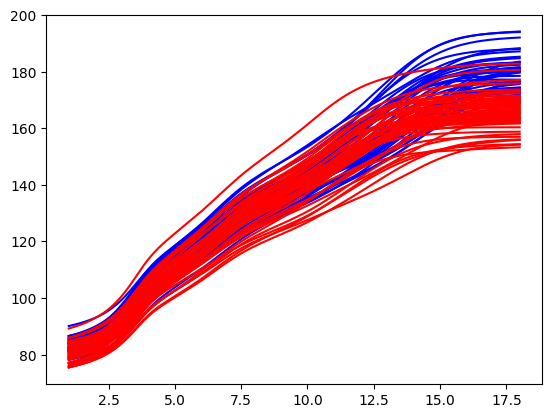

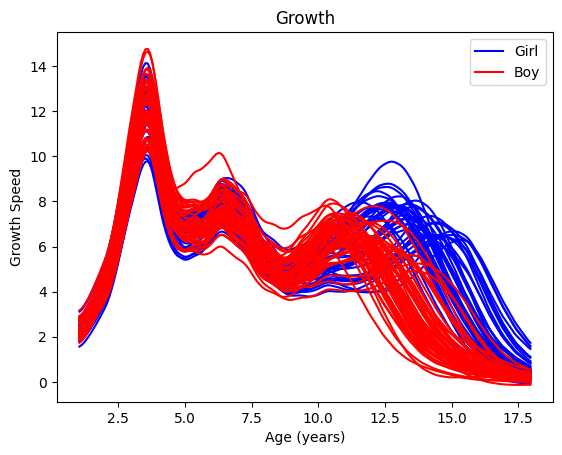

Octane


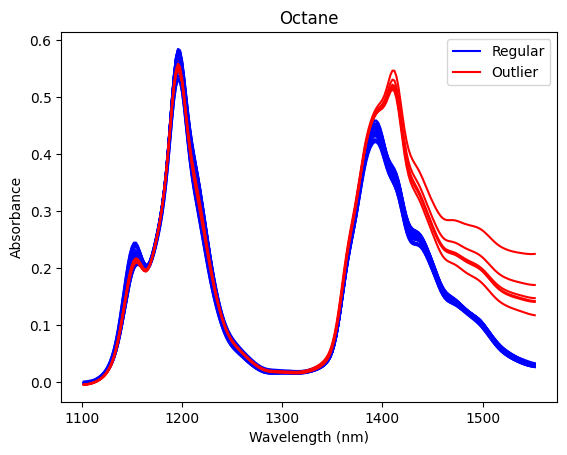

Nox


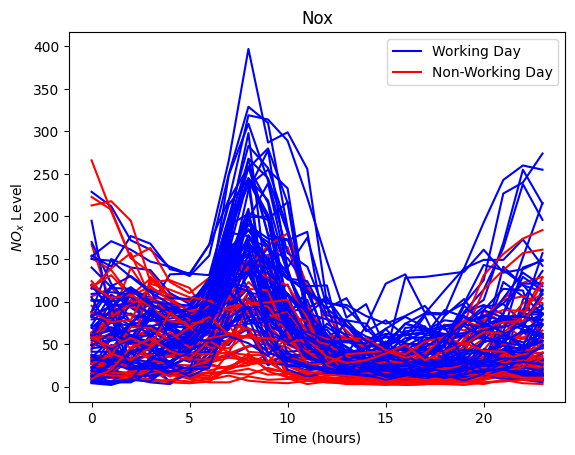

Tecator


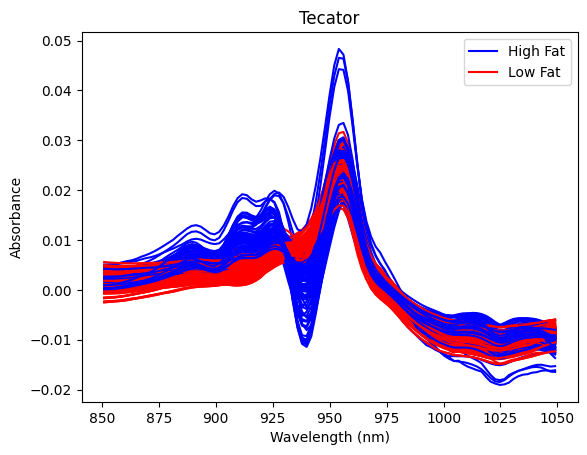

In [36]:
import warnings
warnings.filterwarnings('ignore')

plot=False
clust=False
colors = ['b','r','g','y']
RES = []

for i,fetch in enumerate(DATASETS[:-1]):
    
    print(NAMES[i])
    
    dataset = fetch()
    
    data = dataset['data']
    
    if NAMES[i] == 'Tecator':
        y = dataset['target'][:,0]
        labels = y<20
    else:
        labels = dataset['target']
        
    aux = np.zeros_like(np.unique(labels))    
    FUN = []
    GRID = []
    
    if i ==0:

        b = 3

        smooth = []
        grids = []

        for fd in data:

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            grid = np.linspace(fd.grid_points[0][0],fd.grid_points[0][-1],200)
            x = fd.grid_points[0]
            f_smooth = smooth_numba(f,x,grid,b)

            smooth.append(f_smooth)
            grids.append(grid)
            
        for j,f in enumerate(smooth):
            plt.plot(grids[j],f,c=colors[labels[j]])
        plt.show()

        for j,f in enumerate(smooth):

            x = grids[j]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)
    else:
        for fd in data:

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            x = fd.grid_points[0]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)
            
    for j,f in enumerate(FUN):
        
        grid=GRID[j]
        
        if aux[int(labels[j])]==0:
            plt.plot(grid,f,c=colors[labels[j]],label=LABELS[i][labels[j]])
            aux[int(labels[j])]+=1
        else:
            plt.plot(grid,f,c=colors[labels[j]])
            
            
        
    plt.xlabel(X_LABELS[i])  
    plt.ylabel(Y_LABELS[i])  
    plt.title(NAMES[i])
    plt.legend()
    plt.show()

# Compute Discrepancies

In [37]:
for i,fetch in enumerate(DATASETS):
    
    print('\n',NAMES[i])
    
    if SMOOTH[i]:
        D_I = np.load('./Dataset_Matrices/D_I_up_smooth_'+NAMES[i]+'.npy')
        D_I_l = np.load('./Dataset_Matrices/D_I_low_smooth_'+NAMES[i]+'.npy')
        Norm = np.load('./Dataset_Matrices/Norm_smooth_'+NAMES[i]+'.npy')
        PD = np.load('./Dataset_Matrices/PD_smooth_'+NAMES[i]+'.npy')
    else:
        D_I = np.load('./Dataset_Matrices/D_I_up_'+NAMES[i]+'.npy')
        D_I_l = np.load('./Dataset_Matrices/D_I_low_'+NAMES[i]+'.npy')
        Norm = np.load('./Dataset_Matrices/Norm_'+NAMES[i]+'.npy')
        PD = np.load('./Dataset_Matrices/PD_'+NAMES[i]+'.npy')
        
        
    aux_up = np.triu(D_I).flatten()
    aux_up = aux_up[aux_up>0]
    
    aux_low = np.maximum(D_I_l,PD)
    aux_low = np.triu(aux_low).flatten()
    aux_low = aux_low[aux_low>0]  

    aux_norm = np.triu(Norm).flatten()
    aux_norm = aux_norm[aux_norm>0]
    
    ### DISCREPANCIES
    err_n = (aux_up-aux_low)/aux_up
    
    q95, q90, q85, q80 = np.percentile(np.abs(err_n), [95,90,85,80])
    print('Relative Discrepancies: ',q95, q90, q85, q80)
    
    
    ### INSTABILITIES
    idxs = aux_up>aux_norm
    aux = aux_up[idxs]-aux_norm[idxs]
    aux_n = (aux/aux_up[idxs])
    
    print('Instabilities: ',np.sum(aux_up>aux_norm),np.max(aux_up-aux_norm))
    
    if sum(idxs)>0:
    
        q95, q90, q85, q80 = np.percentile(aux_n, [95,90,85,80])
        print('Relative Instabilities: ',q95, q90, q85, q80)


        


 Growth
Relative Discrepancies:  0.007550414300929801 0.006507322024272975 0.005898491462626434 0.005396812429344453
Instabilities:  0 0.0

 Octane
Relative Discrepancies:  0.00794002703494059 0.006903753111449127 0.006265694827652993 0.005770020523311486
Instabilities:  0 0.0

 Nox
Relative Discrepancies:  0.008105190547234164 0.0070800781977774984 0.006362642637795344 0.005779109558414175
Instabilities:  0 0.0

 Tecator
Relative Discrepancies:  0.007558915593638969 0.006502949523167342 0.005916401040610997 0.005446482749552602
Instabilities:  7 1.37462326400134e-08
Relative Instabilities:  6.4018144126032124e-06 6.375397189450312e-06 6.348979966297411e-06 6.340174224926404e-06

 Tecator
Relative Discrepancies:  0.007558915593638969 0.006502949523167342 0.005916401040610997 0.005446482749552602
Instabilities:  7 1.37462326400134e-08
Relative Instabilities:  6.4018144126032124e-06 6.375397189450312e-06 6.348979966297411e-06 6.340174224926404e-06


# Compute Baselines


 Growth


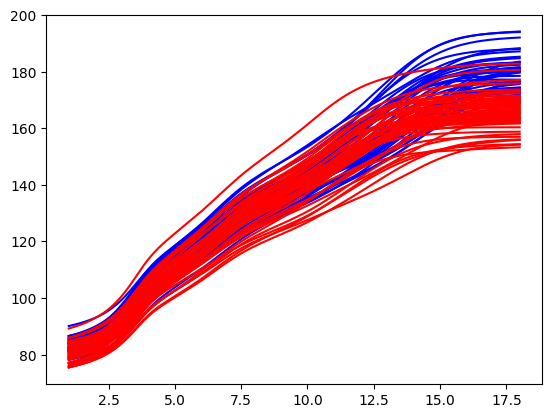

(93, 199)
High Dim Accuracy 48 0.5806451612903226
Accuracy 2 0.9139784946236559
Accuracy 4 0.9139784946236559
Accuracy 6 0.9247311827956989
Accuracy 8 0.9354838709677419
Accuracy 10 0.9247311827956989
Accuracy 12 0.9139784946236559
Accuracy 14 0.8924731182795699
Accuracy 16 0.8709677419354839
Accuracy 18 0.8709677419354839
Accuracy 20 0.8494623655913979
Accuracy 22 0.8279569892473119
Accuracy 24 0.8064516129032258
Accuracy 26 0.7849462365591398
Accuracy 28 0.7634408602150538
Accuracy 30 0.7204301075268817
Accuracy 32 0.7204301075268817
Accuracy 34 0.7419354838709677
Accuracy 36 0.6236559139784946
Accuracy 38 0.5913978494623656
Accuracy 40 0.5806451612903226
Accuracy 42 0.5806451612903226
Accuracy 44 0.5806451612903226

 Octane
(39, 226)
High Dim Accuracy 44 1.0
Accuracy 2 1.0
Accuracy 4 1.0
Accuracy 6 0.8461538461538461
Accuracy 8 0.8461538461538461
Accuracy 10 0.8461538461538461
Accuracy 12 0.8461538461538461
Accuracy 14 0.8461538461538461
Accuracy 16 0.8461538461538461
Accuracy 18 0.

In [13]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

colors = ['b','r','g','y']
RES = []

for i,fetch in enumerate(DATASETS):
    
    print('\n',NAMES[i])
    
    dataset = fetch()
    
    data = dataset['data']
    
    if NAMES[i] == 'Tecator':
        y = dataset['target'][:,0]
        labels = y<20
    else:
        labels = dataset['target']
        

    FUN = []
    GRID = []
    

    if i ==0:

        b = 3

        smooth = []
        grids = []

        for fd in data:

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            grid = np.linspace(fd.grid_points[0][0],fd.grid_points[0][-1],200)
            x = fd.grid_points[0]
            f_smooth = smooth_numba(f,x,grid,b)

            smooth.append(f_smooth)
            grids.append(grid)

        for j,f in enumerate(smooth):

            x = grids[j]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)    
    
    else:
    
        for j,fd in enumerate(data):

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            x = fd.grid_points[0]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)
                
    FUN = np.array(FUN) 
    
    print(FUN.shape)
    
    X = FUN


    if PROBLEMS[i]== 'Class':

        res_van = vanilla_class(X,labels)
        acc_van = (res_van[0][0,0]+res_van[0][1,1])/len(labels)

        print('High Dim Accuracy',n_comp,acc_van)

    else:

        mse = vanilla_regression(X,y)   
        reg_van = LinearRegression().fit(FUN, y)
        pred_van=reg_van.predict(FUN)

        R_van = rsquared(y,pred_van)
        print('High Dim MSE',n_comp,mse)

    
    for n_comp in np.arange(2,min(FUN.shape)//2,2):
    
        pca = PCA(n_components=n_comp, svd_solver='full')
        X = pca.fit_transform(FUN)


        if PROBLEMS[i]== 'Class':

            res_van = vanilla_class(X,labels)
            acc_van = (res_van[0][0,0]+res_van[0][1,1])/len(labels)

            print('Accuracy',n_comp,acc_van)

        else:

            mse = vanilla_regression(X,y)   
            reg_van = LinearRegression().fit(FUN, y)
            pred_van=reg_van.predict(FUN)

            R_van = rsquared(y,pred_van)
            print('MSE',n_comp,mse)

# Beef

In [ ]:
dataset = fetch_ucr('Beef')

data = dataset['data']
labels = dataset['target']

labels = labels-np.min(labels)
labels = labels<1

labels.astype(int)

In [ ]:
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding

PD = np.load('./Dataset_Matrices/PD_Beef.npy')

res_PD = classify(PD,labels)
acc_PD = (res_PD[0][0,0]+res_PD[0][1,1])/len(labels)

MAT_PD,ENNE_PD,NEIGH_PD,_ = res_PD

print('PD Params: ',MAT_PD,ENNE_PD,NEIGH_PD)
print('Accuracy PD: ',acc_PD)

In [ ]:
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding

D_I = np.load('./Dataset_Matrices/D_I_up_Beef.npy')

res_PD = classify(D_I,labels)
acc_PD = (res_PD[0][0,0]+res_PD[0][1,1])/len(labels)

MAT_PD,ENNE_PD,NEIGH_PD,_ = res_PD

print('D_I Params: ',MAT_PD,ENNE_PD,NEIGH_PD)
print('Accuracy D_I: ',acc_PD)

In [ ]:
FUN = np.array(FUN) 

print(FUN.shape)

for n_comp in np.arange(2,min(FUN.shape)//2,2):

    pca = PCA(n_components=n_comp, svd_solver='full')
    X = pca.fit_transform(FUN)


    res_van = vanilla_class(X,labels)
    acc_van = (res_van[0][0,0]+res_van[0][1,1])/len(labels)

    print('Accuracy',n_comp,acc_van)